In [2]:
import folium
from folium.plugins import HeatMapWithTime, HeatMap
import geopy.distance
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import pandas as pd
import pickle


# Import / load data

In [4]:
def open_read( file_name, mode = '',df=''):
        if mode == 'w':
                with open('data/'+file_name, 'wb') as f:
                    pickle.dump(df, f)
        elif mode =='r':
                with open('data/'+file_name, 'rb') as f:
                    df = pickle.load(f)                
                return df

In [5]:
def import_data(filter_by = '', filter_by_not = '', size = 0.1, reload = False, out_file_name = ''):
    
    if reload == True:
        df = pd.DataFrame()
        i = 1
        for file_name in [x for x in os.listdir('data') if (('citi' in x) and \
                        (filter_by in x) and not (filter_by_not in x))]:
            print('Reading file {}, total file nr.:'.format(file_name), i)
            i+=1
            sub_df = pd.read_csv('data/'+file_name, compression='zip')            
            sub_df = sub_df.sample(n = int(round(sub_df.shape[0]*size)))            
            df = df.append(sub_df)#, header=0, sep=',', quotechar='"')
        
        with open('data/'+out_file_name, 'wb') as f:
            pickle.dump(df, f)
            
    else:
        with open('data/'+out_file_name, 'rb') as f:
            df = pickle.load(f)
    
    return df


df = import_data(filter_by = '2018',
                 filter_by_not = 'JC',
                 size = 0.03,
                 reload = True,
                 out_file_name = 'data_35k_no_JC.pkl',
                )

Reading file 201801-citibike-tripdata.csv.zip, total file nr.: 1
Reading file 201802-citibike-tripdata.csv.zip, total file nr.: 2
Reading file 201803-citibike-tripdata.csv.zip, total file nr.: 3
Reading file 201804-citibike-tripdata.csv.zip, total file nr.: 4
Reading file 201805-citibike-tripdata.csv.zip, total file nr.: 5
Reading file 201806-citibike-tripdata.csv.zip, total file nr.: 6
Reading file 201807-citibike-tripdata.csv.zip, total file nr.: 7
Reading file 201808-citibike-tripdata.csv.zip, total file nr.: 8
Reading file 201809-citibike-tripdata.csv.zip, total file nr.: 9
Reading file 201810-citibike-tripdata.csv.zip, total file nr.: 10
Reading file 201811-citibike-tripdata.csv.zip, total file nr.: 11
Reading file 201812-citibike-tripdata.csv.zip, total file nr.: 12


# Inspect & format raw data

In [6]:
print(df.columns.tolist())

['tripduration', 'starttime', 'stoptime', 'start station id', 'start station name', 'start station latitude', 'start station longitude', 'end station id', 'end station name', 'end station latitude', 'end station longitude', 'bikeid', 'usertype', 'birth year', 'gender']


In [7]:
mapper = {'end station name':'es_name',
          'start station name':'ss_name',
          'start station latitude':'ss_lat',
          'start station longitude':'ss_lon',
          'end station latitude':'es_lat',
          'end station longitude':'es_lon',
          'start station id':'ss_id',
          'end station id':'es_id',
          'birth year':'birth_year',
          'bikeid':'bike_id',
          'tripduration':'trip_duration'
         }

df = df.rename(columns = mapper)

In [285]:
n_obs_orig = df.shape[0]
print(df.shape)

(526341, 25)


In [286]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 526341 entries, 612522 to 586281
Data columns (total 25 columns):
trip_duration          526341 non-null int64
starttime              526341 non-null datetime64[ns]
stoptime               526341 non-null datetime64[ns]
ss_id                  526341 non-null int64
ss_name                526341 non-null object
ss_lat                 526341 non-null float64
ss_lon                 526341 non-null float64
es_id                  526341 non-null int64
es_name                526341 non-null object
es_lat                 526341 non-null float64
es_lon                 526341 non-null float64
bike_id                526341 non-null int64
usertype               526341 non-null object
birth_year             526341 non-null int64
gender                 526341 non-null int64
age                    526341 non-null int64
starttime_hour         526341 non-null int64
starttime_month        526341 non-null int64
starttime_dayofweek    526341 non-null int64


In [287]:
print(df.head())

        trip_duration               starttime                stoptime  ss_id  \
612522            151 2018-01-16 08:07:39.215 2018-01-16 08:10:10.707   3354   
296896            384 2018-01-16 06:06:40.090 2018-01-16 06:13:04.428    467   
28724             884 2018-01-18 01:35:26.099 2018-01-18 01:50:10.798    174   
20121             459 2018-01-03 17:00:50.019 2018-01-03 17:08:29.079    167   
446978            636 2018-01-22 18:33:32.777 2018-01-22 18:44:09.297   2000   

                          ss_name     ss_lat     ss_lon  es_id  \
612522  3 St & Prospect Park West  40.668132 -73.973638   3300   
296896            Dean St & 4 Ave  40.683125 -73.978951   3402   
28724             E 25 St & 1 Ave  40.738177 -73.977387    350   
20121             E 39 St & 3 Ave  40.748901 -73.976049    533   
446978   Front St & Washington St  40.702551 -73.989402    531   

                          es_name     es_lat       ...        age  \
612522  Prospect Park West & 8 St  40.665147       ..

In [288]:
print(df.describe())

       trip_duration         ss_id         ss_lat         ss_lon  \
count   5.263410e+05  526341.00000  526341.000000  526341.000000   
mean    9.579411e+02    1586.06481      40.737295     -73.982652   
std     1.244001e+04    1438.99352       0.031262       0.019066   
min     6.100000e+01      72.00000      40.646538     -74.025353   
25%     3.580000e+02     380.00000      40.717548     -73.995209   
50%     6.040000e+02     505.00000      40.738177     -73.985649   
75%     1.059000e+03    3249.00000      40.757632     -73.972834   
max     3.697580e+06    3721.00000      45.506264     -73.568906   

               es_id         es_lat         es_lon        bike_id  \
count  526341.000000  526341.000000  526341.000000  526341.000000   
mean     1581.818606      40.736959     -73.982851   26562.357667   
std      1438.829505       0.031066       0.019147    6221.529194   
min        72.000000      40.646538     -74.025353   14529.000000   
25%       380.000000      40.717548     -7

In [289]:
print(df.isnull().sum()/df.isnull().count()*100)

trip_duration          0.0
starttime              0.0
stoptime               0.0
ss_id                  0.0
ss_name                0.0
ss_lat                 0.0
ss_lon                 0.0
es_id                  0.0
es_name                0.0
es_lat                 0.0
es_lon                 0.0
bike_id                0.0
usertype               0.0
birth_year             0.0
gender                 0.0
age                    0.0
starttime_hour         0.0
starttime_month        0.0
starttime_dayofweek    0.0
stoptime_hour          0.0
stoptime_month         0.0
stoptime_dayofweek     0.0
stations_distance      0.0
route                  0.0
trip_eff_speed         0.0
dtype: float64


#  Check for duplicates

In [290]:
x = df.groupby('ss_id')['ss_lat'].nunique()
print(x.loc[x > 1])
x = df.groupby('ss_id')['ss_lon'].nunique()
print(x.loc[x > 1])
x = df.groupby('es_id')['es_lat'].nunique()
print(x.loc[x > 1])
x = df.groupby('es_id')['es_lon'].nunique()
print(x.loc[x > 1])

ss_id
530    2
Name: ss_lat, dtype: int64
ss_id
530    2
Name: ss_lon, dtype: int64
es_id
530    2
Name: es_lat, dtype: int64
es_id
530    2
Name: es_lon, dtype: int64


# Clean missing values

In [9]:
df = df.drop(df.index[df['ss_id'].isnull()])
print(df.shape)
print(df.isnull().sum()/df.isnull().count()*100)

(526341, 15)
trip_duration    0.0
starttime        0.0
stoptime         0.0
ss_id            0.0
ss_name          0.0
ss_lat           0.0
ss_lon           0.0
es_id            0.0
es_name          0.0
es_lat           0.0
es_lon           0.0
bike_id          0.0
usertype         0.0
birth_year       0.0
gender           0.0
dtype: float64


#  Format data types, generate new features

In [10]:
df['starttime'] = df['starttime'].astype('str')
df['stoptime'] = df['stoptime'].astype('str')
#df['Start Station Name'] = df['Start Station Name'].astype('category')
#df['End Station Name'] = df['End Station Name'].astype('category')
df['ss_id'] = df['ss_id'].astype('int64')
df['es_id'] = df['es_id'].astype('int64')
df['gender'] = df['gender'].astype('int64')
df['age'] = 2018 - df['birth_year'] 


cols_to_dt = ['starttime', 'stoptime']
for col in cols_to_dt:
    
    df[col] = df[col].apply(lambda x: pd.to_datetime(x,format = '%Y-%m-%d %H:%M:%S.%f'))
    df[col+'_hour'] = df[col].apply(lambda x: x.hour)
    df[col+'_month'] = df[col].apply(lambda x: x.month)
    df[col+'_dayofweek'] = df[col].apply(lambda x: x.dayofweek)

In [12]:
def get_distance(row):
    return geopy.distance.vincenty((row.ss_lat, row.ss_lon), (row.es_lat, row.es_lon)).m   
    
df['stations_distance'] = df.apply(lambda x: get_distance(x), axis = 1)

C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  from ipykernel import kernelapp as app


In [80]:
df['route'] = df.apply(lambda x: str(x.ss_id)+'_'+str(x.es_id), axis = 1)
n_trips_per_route = df['route'].value_counts()
min_speed_per_route = df.groupby('route').trip_duration.quantile(0.01)

def get_eff_speed(row, speed_frame):
    
    min_speed_on_station = speed_frame[row.route]
    return row.trip_duration/min_speed_on_station
    

df['trip_eff_speed'] = df.apply(lambda x: get_eff_speed(x,min_speed_per_route), axis = 1)

In [5]:
#x = open_read(df,'0.03_intermediate', mode = 'w')
df = open_read('0.03_intermediate', mode = 'r')

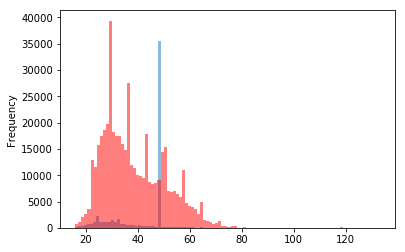

In [13]:
df_1 = df.loc[df.usertype == 'Customer']
df_2 = df.loc[df.usertype == 'Subscriber']
fig, ax = plt.subplots()

df_1.age.plot.hist(bins = 100, ax = ax, alpha = 0.5)
df_2.age.plot.hist(bins = 100, ax = ax, color = 'red', alpha = 0.5)
plt.show()

# Explore / visualize data

###  Stations

In [7]:
df['ss_id'].nunique()

811

In [8]:
loc = [40.747231, -73.989632]
tiles = 'Stamen Toner'
zoom_start = 10
m = folium.Map(location = loc,tiles = tiles, zoom_start = zoom_start)
coords = []

for index, row in df.groupby('ss_id')['ss_lat', 'ss_lon'].max().iterrows():
    folium.Circle((row.ss_lat, row.ss_lon),
                  poppop = str(row.ss_lat)+' ,'+str(row.ss_lon),
                  radius = 50).add_to(m)
                  
m.save('data/map_stations.html')

[]

In [9]:
%%HTML
<iframe width = "100%", height = "600", src = "data/map_stations.html"></iframe>

### Heatmap of starting stations used per hour

In [281]:
data = []
f = 0.0015

for i in range(24):
    sub_df = df.loc[(df.starttime_hour == i)& ~(df.starttime_dayofweek.isin( [0,1,2,3,4]))][['ss_lat', 'ss_lon']]
    x = [[row.ss_lat+np.random.random()*f, row.ss_lon+np.random.random()*f] for index, row in sub_df.iterrows()]
    data.append(x)

In [299]:
m = folium.Map(location = loc, tiles = tiles, zoom_start = zoom_start)    
hm = HeatMapWithTime(data = data,index = [i for i in range(24)],  radius = 2.5,
                     min_opacity = 0.05, max_opacity = .65, use_local_extrema = True)
hm.add_to(m)
hm.save('data/heatmap_star_loc.html')

In [300]:
%%HTML
<iframe width = "100%", height = "600", src = "data/heatmap_star_loc.html"></iframe>

###  Heatmap of end stations used per hour

In [13]:
data = []
f = 0.002

for i in range(24):
    sub_df = df.loc[df.stoptime_hour == i][['es_lat', 'es_lon']]
    x = [[row.es_lat+np.random.random()*f, row.es_lon+np.random.random()*f] for index, row in sub_df.iterrows()]
    data.append(x)

In [14]:
m = folium.Map(location = loc, tiles = tiles, zoom_start = zoom_start)    
hm = HeatMapWithTime(data = data,index = [i for i in range(24)],  radius = 2)
hm.add_to(m)
hm.save('data/heatmap_stop_loc.html')

In [15]:
%%HTML
<iframe width = "100%", height = "600", src = "data/heatmap_stop_loc.html"></iframe>

###  Distance between stations

count    526341.000000
mean          1.784353
std           1.424479
min           0.000000
1%            0.000000
5%            0.340849
10%           0.505154
20%           0.725843
30%           0.922233
40%           1.132199
50%           1.370138
60%           1.664914
70%           2.051062
80%           2.618488
90%           3.639923
95%           4.698152
99%           6.926706
max          16.513486
Name: stations_distance, dtype: float64


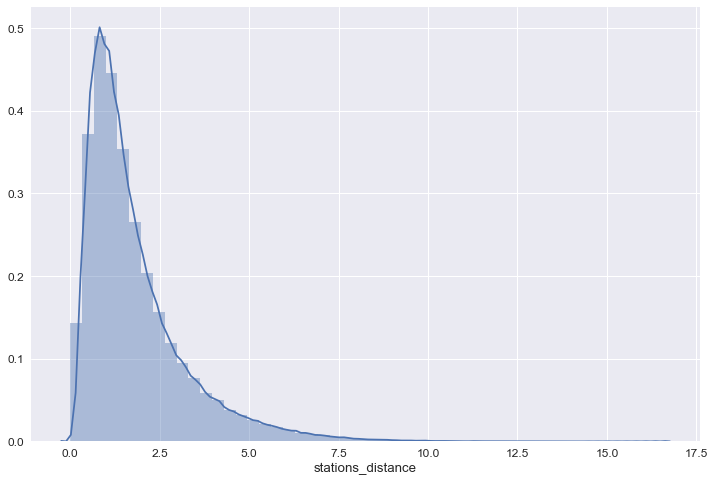

In [266]:
sns.set(style='whitegrid')
sns.set(font_scale=1.2)
fix, ax = plt.subplots(figsize=(12,8))
print((df.stations_distance/1000).describe([.01,.05,.1,.2,.3,.4,.5,.6,.7,.8,.9,.95,.99]))
sns.distplot(df.stations_distance/1000)
plt.show()

###  Number of bikes & trips

In [26]:
print(df.bike_id.nunique())
print(df.shape[0])

14869
526341


###  Trip information

count     811.000000
mean      649.002466
std       615.053178
min         1.000000
1%          2.100000
5%         64.000000
10%       101.000000
20%       160.000000
30%       232.000000
40%       321.000000
50%       413.000000
60%       571.000000
70%       799.000000
80%      1126.000000
90%      1528.000000
95%      1896.500000
99%      2527.100000
max      4497.000000
Name: Number of trips, dtype: float64


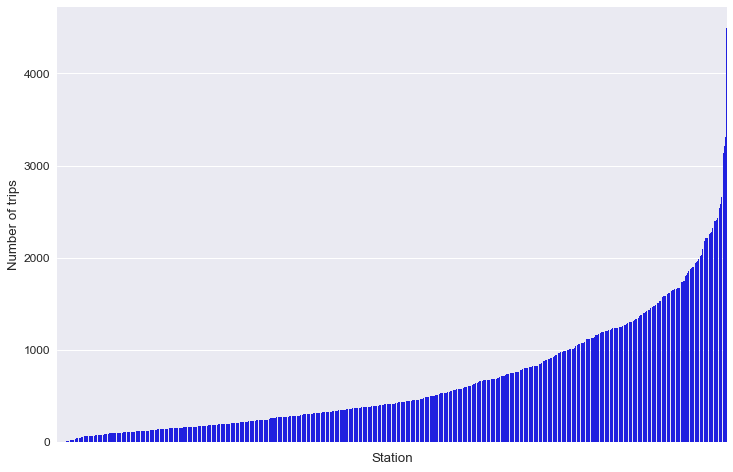

In [261]:
#TODO analyse stations with low trips
sns.set(style='whitegrid')
sns.set(font_scale=1.2)
fig, ax = plt.subplots(figsize = (12,8))
grouped_df = df.groupby('ss_id')['ss_id'].count().rename('Number of trips').sort_values().reset_index()
sns.barplot(x='ss_id', y='Number of trips', data=grouped_df, order = grouped_df.ss_id.tolist(),color = 'blue')
ax.set_xlabel('Station')
ax.set_ylabel('Number of trips')
ax.set_xticklabels([])
print(grouped_df['Number of trips'].describe([.01,.05,.1,.2,.3,.4,.5,.6,.7,.8,.9,.95,.99]))
plt.show()

count    14869.000000
mean        35.398547
std         16.937299
min          1.000000
1%           2.000000
5%           7.000000
10%         13.000000
20%         21.000000
30%         27.000000
40%         31.000000
50%         35.000000
60%         38.000000
70%         42.000000
80%         49.000000
90%         59.000000
95%         66.000000
99%         78.000000
max        113.000000
Name: trip_duration, dtype: float64


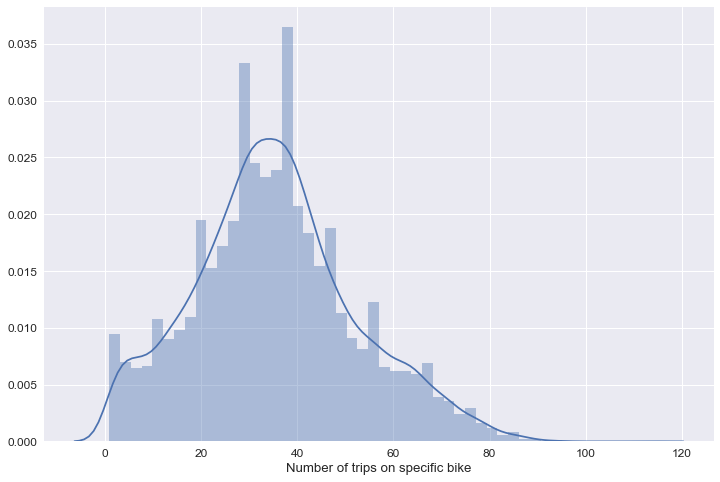

In [267]:
#TODO: answer question while considering first trip of bike
sns.set(style='whitegrid')
sns.set(font_scale=1.2)
fig, ax = plt.subplots(figsize = (12,8))
grouped_df = df.groupby('bike_id')['trip_duration'].count()
sns.distplot(grouped_df)
ax.set_xlabel('Number of trips on specific bike')
print(grouped_df.describe([.01,.05,.1,.2,.3,.4,.5,.6,.7,.8,.9,.95,.99]))
plt.show()

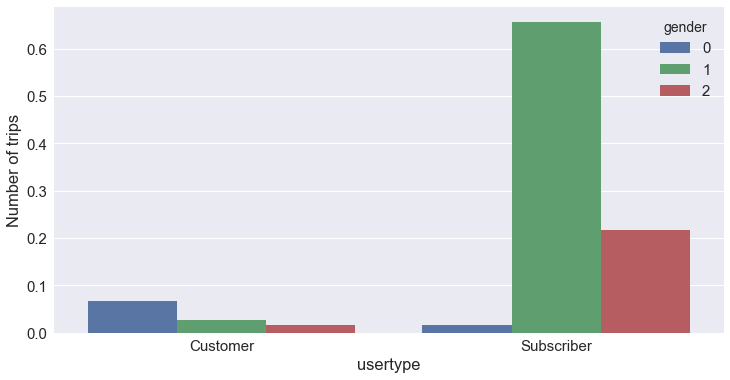

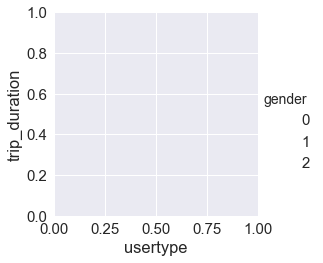

In [31]:
sns.set(style='whitegrid')
sns.set(font_scale=1.5)
fig, ax = plt.subplots(figsize=(12,6))
grouped_df = df.groupby(['gender','usertype'])['trip_duration'].count().div(df.shape[0]).reset_index()
sns.factorplot(x='usertype', y='trip_duration', hue = 'gender', data=grouped_df, kind = 'bar', ax = ax)
ax.set_ylabel('Number of trips')
plt.show()

### Visualization of feature distributions by usertype

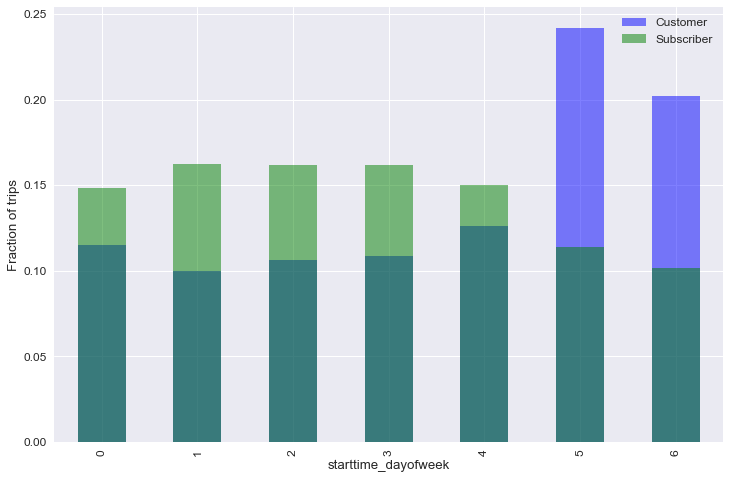

In [34]:
customers = df.groupby(['usertype'])['trip_duration'].count().loc['Customer']
subscribers = df.groupby(['usertype'])['trip_duration'].count().loc['Subscriber']

sns.set(style='whitegrid')
sns.set(font_scale=1.2)
grouped_df = df.groupby(['starttime_dayofweek','usertype'])['trip_duration'].count()
grouped_df_customers = grouped_df.loc[:, 'Customer'].div(customers)
grouped_df_subscribers = grouped_df.loc[:, 'Subscriber'].div(subscribers)

fig, ax = plt.subplots(figsize =(12,8))
grouped_df_customers.plot(kind='bar', color ='blue', alpha = 0.5, label = 'Customer')
grouped_df_subscribers.plot(kind='bar', color ='green', alpha = 0.5, label = 'Subscriber')
ax.legend()
ax.set_ylabel('Fraction of trips')
plt.show()

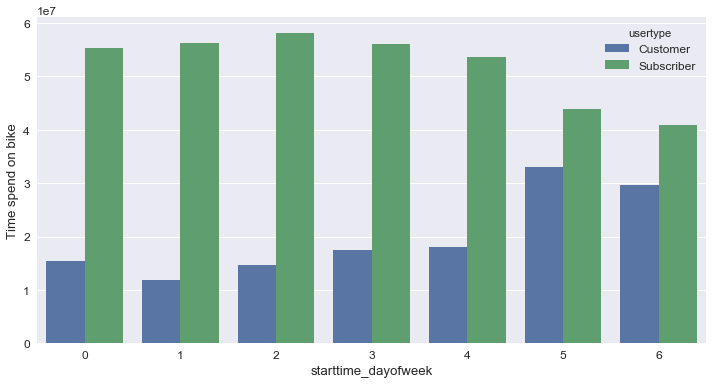

In [85]:
sns.set(style='whitegrid')
sns.set(font_scale=1.2)
fig, ax = plt.subplots(figsize=(12,6))
grouped_df = df.groupby(['starttime_dayofweek','usertype'])['trip_duration'].sum().reset_index()
sns.barplot(x='starttime_dayofweek', y='trip_duration', data=grouped_df, hue = 'usertype')
ax.set_ylabel('Time spend on bike')
plt.show()

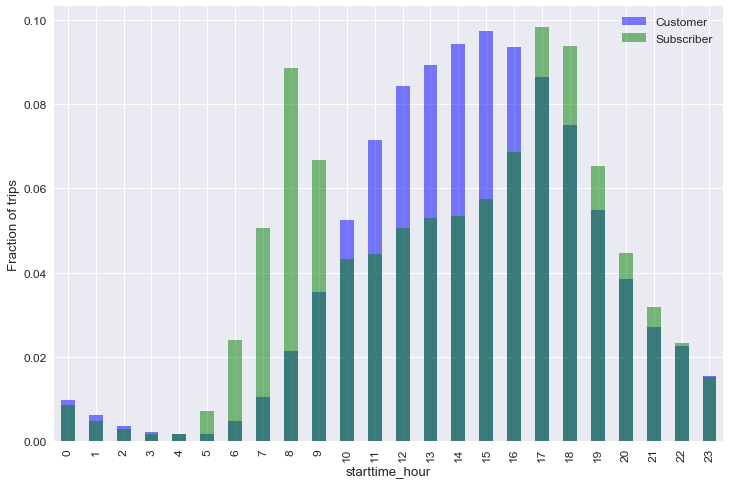

In [257]:
sns.set(style='whitegrid')
sns.set(font_scale=1.2)
grouped_df = df.groupby(['starttime_hour','usertype'])['trip_duration'].count()
grouped_df_customers = grouped_df.loc[:, 'Customer'].div(customers)
grouped_df_subscribers = grouped_df.loc[:, 'Subscriber'].div(subscribers)

fig, ax = plt.subplots(figsize =(12,8))
grouped_df_customers.plot(kind='bar', color ='blue', alpha = 0.5, label = 'Customer')
grouped_df_subscribers.plot(kind='bar', color ='green', alpha = 0.5, label = 'Subscriber')
ax.legend()
ax.set_ylabel('Fraction of trips')
plt.show()

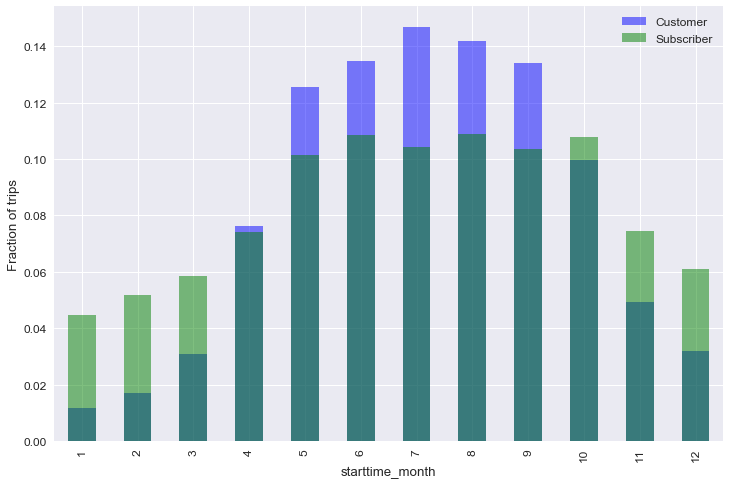

In [258]:
sns.set(style='whitegrid')
sns.set(font_scale=1.2)
grouped_df = df.groupby(['starttime_month','usertype'])['trip_duration'].count()
grouped_df_customers = grouped_df.loc[:, 'Customer'].div(customers)
grouped_df_subscribers = grouped_df.loc[:, 'Subscriber'].div(subscribers)

fig, ax = plt.subplots(figsize =(12,8))
grouped_df_customers.plot(kind='bar', color ='blue', alpha = 0.5, label = 'Customer')
grouped_df_subscribers.plot(kind='bar', color ='green', alpha = 0.5, label = 'Subscriber')
ax.legend()
ax.set_ylabel('Fraction of trips')
plt.show()

count    5.263410e+05
mean     9.579411e+02
std      1.244001e+04
min      6.100000e+01
1%       1.010000e+02
5%       1.710000e+02
10%      2.270000e+02
20%      3.150000e+02
30%      4.010000e+02
40%      4.940000e+02
50%      6.040000e+02
60%      7.440000e+02
70%      9.340000e+02
80%      1.212000e+03
90%      1.655000e+03
95%      2.073000e+03
99%      3.476000e+03
max      3.697580e+06
Name: trip_duration, dtype: float64


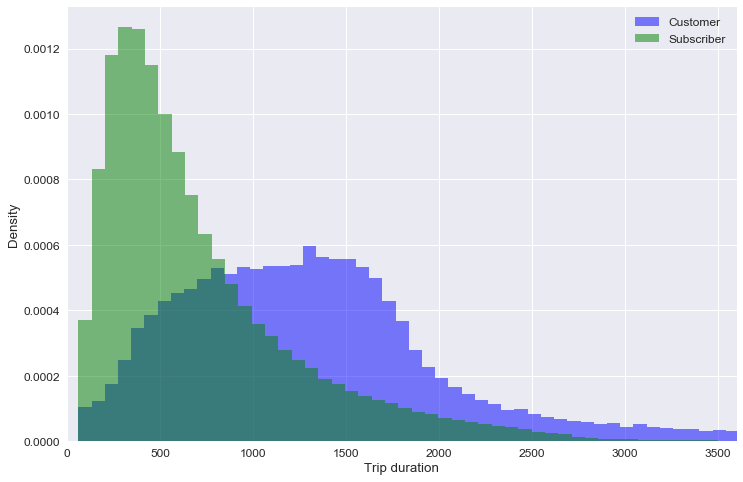

In [269]:
fig, ax = plt.subplots(figsize=(12,8))
df.loc[(df['trip_duration'] < 60*60*4) & (df.usertype == 'Customer')]['trip_duration'].hist(ax = ax,
                                        bins  = 200, alpha = 0.5, normed = True, color = 'b', label = 'Customer')
df.loc[(df['trip_duration'] < 60*60*4) & (df.usertype != 'Customer')]['trip_duration'].hist(ax = ax, bins  = 200,
                                        alpha = 0.5, color = 'green', normed = True, label = 'Subscriber')
ax.set_ylabel('Density')
ax.set_xlim((0,60*60*1))
ax.set_xlabel('Trip duration')
ax.legend()
print(df['trip_duration'].describe([.01,.05,.1,.2,.3,.4,.5,.6,.7,.8,.9,.95,.99]))
plt.show()

count    526341.000000
mean          2.157131
std          21.869028
min           0.061437
1%            0.977725
5%            0.993849
10%           0.998214
20%           1.000000
30%           1.064023
40%           1.164186
50%           1.266386
60%           1.382038
70%           1.528899
80%           1.754844
90%           2.350197
95%           3.849776
99%          18.517404
max       13446.358447
Name: trip_eff_speed, dtype: float64


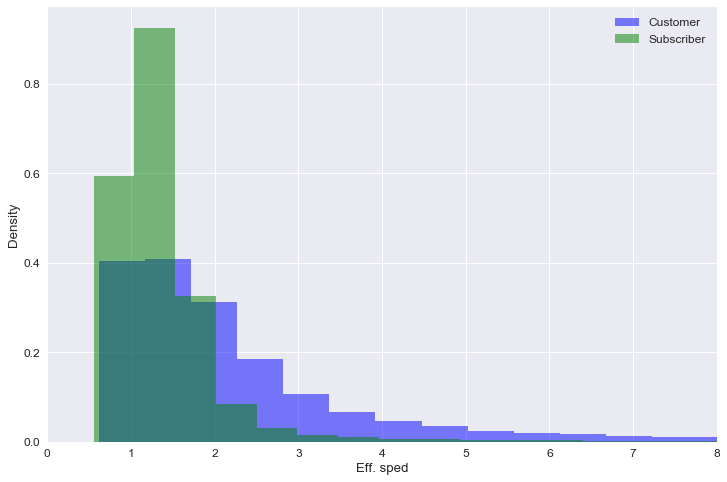

In [270]:
fig, ax = plt.subplots(figsize=(12,8))
df.loc[(df['trip_duration'] < 60*60*4) & (df.usertype == 'Customer')]['trip_eff_speed'].hist(ax = ax, bins  = 400,
                                    alpha = 0.5, normed = True, color = 'b', label = 'Customer')
df.loc[(df['trip_duration'] < 60*60*4) & (df.usertype != 'Customer')]['trip_eff_speed'].hist(ax = ax, bins  = 400,
                                    alpha = 0.5, color = 'green', normed = True, label = 'Subscriber')
ax.set_ylabel('Density')
ax.set_xlim((0,8))
ax.set_xlabel('Eff. sped')
ax.legend()
print(df['trip_eff_speed'].describe([.01,.05,.1,.2,.3,.4,.5,.6,.7,.8,.9,.95,.99]))#, fontdict = { 'verticalalignment': 'top',
                                    #             'horizontalalignment': 'right'})
plt.show()

count    526341.000000
mean       1784.352604
std        1424.479177
min           0.000000
1%            0.000000
5%          340.849181
10%         505.153774
20%         725.843337
30%         922.232901
40%        1132.199300
50%        1370.138155
60%        1664.913946
70%        2051.062049
80%        2618.487673
90%        3639.923019
95%        4698.152441
99%        6926.705828
max       16513.486265
Name: stations_distance, dtype: float64


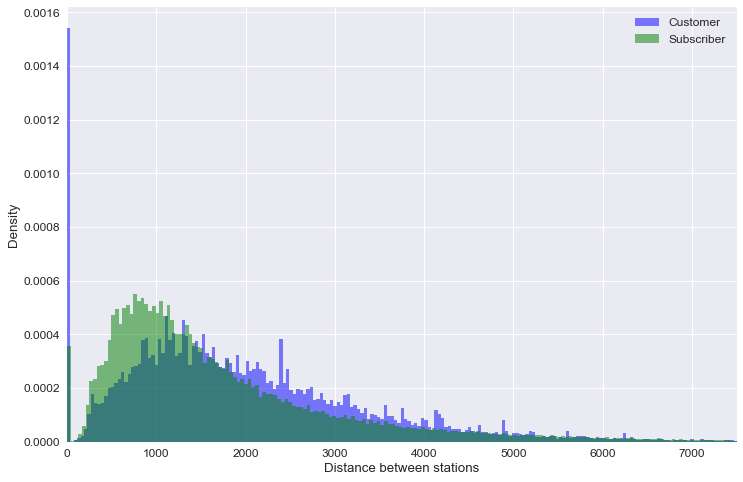

In [271]:
# TODO answer if zero distance seperates
fig, ax = plt.subplots(figsize=(12,8))
df.loc[(df['trip_duration'] < 60*60*4) & (df.usertype == 'Customer')]['stations_distance'].hist(ax = ax, bins  = 400,
                                    alpha = 0.5, normed = True, color = 'b', label = 'Customer')
df.loc[(df['trip_duration'] < 60*60*4) & (df.usertype != 'Customer')]['stations_distance'].hist(ax = ax, bins  = 400,
                                    alpha = 0.5, color = 'green', normed = True, label = 'Subscriber')
ax.set_ylabel('Density')
ax.set_xlim((0,7500))
ax.set_xlabel('Distance between stations')
ax.legend()
print(df['stations_distance'].describe([.01,.05,.1,.2,.3,.4,.5,.6,.7,.8,.9,.95,.99]))#, fontdict = { 'verticalalignment': 'top',
                                    #             'horizontalalignment': 'right'})
plt.show()